<h1 style="font-size: 40px; margin-bottom: 0px;">8.1 Exploring peak data and motif discovery</h1>

<hr style="margin-left: 0px; border: 0.25px solid; border-color: #000000; width: 98%;"></hr>

<p style="color:#FF0000;"><strong>For those of you following along after class, do not use the "Restart kernal and run all cells" option. This notebook isn't set up to be run like that. You should run commands in Terminal, and the Python parts in this notebook.</strong></p>

Last week, we used <code>bowtie2</code> to align our raw reads to the hg19 reference genome. We then took those aligned reads and visualized the aligned reads using IGV. We then used <code>macs2</code> to identify significant and enriched peaks in our taz_1 and taz_2 datasets, and we were able to see how the reads pile up on both sides of the footprint of a DNA binding protein.

Today, first start off with some housekeeping as we're now generating a lot more data and also a lot more large data files. Then, we'll explore our peak data some more, making use of a program called <a href="http://homer.ucsd.edu/homer/" rel="noopener noreferrer" target="_blank"><u>HOMER (Hypergeometric Optimization of Motif EnRichment)</u></a>. First, we'll build HOMER into our Biology Hub server, then we will use it to take a look at the distribution of our reads around our summits. <strong>While you can run HOMER in your notebook, it'll be easier to run the installation and your HOMER commands in Terminal.</strong>

We'll also take a closer look at our peak data by looking at the intersection of our peaks, and taking a look at the concordance of the two TAZ replicates. Recall from lecture that Dr. Ingolia talked about analyzing the reproducibility of our data using the Irreproducibile Discovery Rate (IDR). We'll take a qualitative look at the IDR of our two TAZ replicates when we play around with the intersection of their called peaks.

Once we've identified our set of reproducible peaks, we can perform motif discovery on the overlapping peaks to see what are the binding sites recognized by the DNA binding protein(s) that TAZ is interacting with in order to regulate gene expression.

<strong>Learning objectives:</strong>

<ul>
    <li>General housekeeping</li>
    <li>Learn to install and use HOMER</li>
    <li>Learn to plot the peak profile</li>
    <li>Identify overlapping peaks</li>
    <li>Take a basic look at the concordance of the two replicates</li>
    <li>Pull data from peaks ranking highly in both replicates</li>
    <li>Identify binding motifs for TEAD+TAZ</li>
</ul>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

<h1 style="font-size: 40px; margin-bottom: 0px;">Housekeeping and backing up files</h1>

<hr style="margin-left: 0px; border: 0.25px solid; border-color: #000000; width: 98%;"></hr>

Since we're generating large data files, some of which are transitional files, we can do some general housekeeping before proceeding with today's lesson to help the Biology Hub maintainers keep storage needs and costs down. We'll play around in Terminal to poke around our server and see if we can reduce some of our storage footprint. We'll do this portion of the lab notebook in Terminal since it'll be easier to move around.

<h2>Checking directory sizes through Terminal</h2>

While we can hover over files in our File Browser to take a look at the file size, when we do the same thing with directories, we don't get any file size shown. So we'll make use of Terminal to take a look at how large our directories are overall and to identify potential areas where we can tidy up our server.

In [ ]:
%%bash

#You'll want to work in Terminal rather than in this notebook for any command line stuff

#Change to home directory
cd ~

#We'll take a look at disk usage (du) at the level of our home directory (which includes shared directories)
du -sh .
#-sh is actually two short-form options -s and -h just combined together into -sh
##-s indicates that we want a summary - so not individual directories or files just overall 
##-h indicates we want a "human readable" output, so we'll be able to see it as G (gigabytes), M (megabytes), etc
##The period just indicates that we want to analyze disk usage for our current directory

#You'll see a large gigabyte usage, but this is because of the shared directories
#We can just analyze those directories to see what their contribution is
du -sh ./shared

du -sh ./_shared

#We can specify that we want to exclude these from our analysis
du -sh --exclude=./shared --exclude=./_shared .
#If your output is larger than 25G, then you'll need to reduce your storage usage to alleviate burden for the Biology Hub
#If your output is ~10G, then you don't need to worry about anything.

#We can take a look at our main course directory
du -sh ~/MCB201B_F2025

#We can change how du operates so that it doesn't output a summary anymore and ignore some notebook checkpoints and .git files that get pulled into our directory from our repo
du -h --exclude=.ipynb_checkpoints --exclude=git* ~/MCB201B_F2025
#You'll see various files, and our large directories will be our alignment ones
#The asterisk is a wildcard for pattern matching. Essentially as long as the string matches .git, anything after doesn't matter and will be included

#We can specify a threshold to just show those files above a certain size
du -h --exclude=.ipynb_checkpoints --exclude=.git* --threshold=1G ~/MCB201B_F2025
#Here we output only directories larger than 1gigabye

#We can also sort the output based on their size by piping into sort
du -h --exclude=.ipynb_checkpoints --exclude=.git* --threshold=1G ~/MCB201B_F2025 | sort -h

#You'll want to take a look at your large file directories and find large files that we don't need anymore
#You'll then want to delete those large files we don't need anymore to reduce storage footprint

<h2>Back up <code>MCB201A_Su2025</code></h2>

For those of you who want to keep your MCB201A files, go ahead and download your <code>MCB201A_Su2025</code> directory, so that you have it saved as a compressed folder on your laptop.

<h2>Delete your server's copy of <code>MCB201A_Su2025</code></h2>

With <code>MCB201A_Su2025</code> backed up, let's go ahead and delete our server's copy of it.

In [ ]:
%%bash

#Only do this once you've backed up your MCB201A_Su2025 directory (if you want to keep a copy of it)
rm -rf ~/MCB201A_Su2025
#This also combines two short-form options -r (recursive operation) and -f (basically auto-confirm any need to confirm deletions)

<h2>Finding files known to be large</h2>

We know that we have particular output files that are known to be large, so we can use the <code>find</code> command to then identify those large files.

In [ ]:
%%bash

#We can find common large files, basically our .sam files
find ~/MCB201B_F2025 -type f -name "*.sam"
#find command will search through the given directory
#with the -type f option and argument, we tell find to focus just on files and not directories
#with the -name "*.sam" option and argument, we specify that the file name should match the wildcard+.sam, essentially any file with a .sam extension

Then we can feed the output from the <code>find</code> command to the <code>du</code> command to get an output of the size of those files. We'll also modify how both commands are running in order to get a specific output from <code>find</code> that can be understood by <code>du</code> and to let <code>du</code> know that it will read in the file names from the standard input.

In [ ]:
%%bash

#If we want, we can feed the output into du. We didn't do this in class, but if you want
find ~/MCB201B_F2025 -type f -name "*.sam" -print0 | du -h --files0-from=-
#We pipe the output of a particular format indicated by -print0 into du which we prepare to accept a particular format from the standard input using --files0-from=-

We can then also use the <code>find</code> command to then delete those files as well.

In [ ]:
%%bash

#To delete our SAM files
#First make sure you completed the homework and don't need the .sam files anymore
#Then delete them either manually via the File Browser, or using the code below
find ~/MCB201B_F2025 -type f -name "*.sam" -delete
#The additional -delete option will perform the delete action on the files that were found

<h1 style="font-size: 40px; margin-bottom: 0px;">Installing HOMER</h1>

<hr style="margin-left: 0px; border: 0.25px solid; border-color: #000000; width: 98%;"></hr>

HOMER is a multifunctional program that can not only perform motif discovery, which is what we'll be primarily using it for, but it also has a lot of next-gen sequencing analysis functionality. For instance, it can also be used to call peaks, much like macs2.

HOMER was primarily developed by Chris Benner at UCSD.

I've placed a <code>configureHomer.pl</code> file in our shared class ChIP-seq directory. This file will be used to install the files needed for HOMER to run on your Biology Hub server.

First, you'll want to make a new directory in your home directory that will hold a <u>copy</u> of the <code>configureHomer.pl</code> file.

<h2>Change to home directory</h2>

In [ ]:
%%bash

#All the HOMER stuff should also be done through Terminal as well not in the notebook code cells

cd ~

<hr style="margin-left: 0px; border: 1px solid; border-color: #BBBBBB; width: 98%;"></hr>

<h2>Make a new directory called <code>homer</code> in your home directory</h2>

In [ ]:
%%bash

mkdir homer

<hr style="margin-left: 0px; border: 1px solid; border-color: #BBBBBB; width: 98%;"></hr>

<h2>Enter <code>homer</code> directory and copy over <code>configureHomer.pl</code> to it</h2>

In [ ]:
%%bash

#Change into homer
cd homer

#Copy over the configureHomer.pl file it is a dot, P, and L (lower-case) file extension for a Perl script
cp ~/shared/2025-fall/courses/1547808/chip-seq/configureHomer.pl ./

<hr style="margin-left: 0px; border: 1px solid; border-color: #BBBBBB; width: 98%;"></hr>

<h2>Run <code>configureHomer.pl</code></h2>

Once you've copied over <code>configureHomer.pl</code>, you'll now need to run it in order to install the necessary files. Since this file uses Perl, another coding language, we will need to run it directly in command line.

In [ ]:
%%bash

#You should still be in homer directory in Terminal
#Run the perl script to install HOMER
perl configureHomer.pl -install

There might be a few warnings, but there shouldn't be any errors.

<hr style="margin-left: 0px; border: 1px solid; border-color: #BBBBBB; width: 98%;"></hr>

<h2>Update PATH to be able to run HOMER</h2>

We'll need to tell Terminal where to go to find the different files that HOMER uses. This temporarily adds the directories that HOMER uses to your <code>PATH</code> variable, but since the server reinitializes things, you'll need to go to your <code>homer</code> directory and re-run this line to update the <code>PATH</code> variable each time you start up your server.

In [ ]:
%%bash

#We'll update our PATH variable
#This is so Terminal knows where to look to find the scripts for HOMER

#First we can take a look at our PATH variable
echo $PATH
#The dollar sign basically indicates you are invoking a variable
#In our case, the variable is PATH
#The output into Terminal is all the different paths that contain binaries that we can run
#Like for R and conda and our local binaries
#We'll add a path for Terminal to find the HOMER scripts

#We are assigning to the PATH variable $PATH:/home/jovyan/homer/bin
PATH=$PATH:/home/jovyan/homer/bin
#Basically what's going on is that we're calling up the PATH variable with $PATH
#And by tacking on :/home/jovyan/homer/bin
#We are appending that string onto what the PATH variable already has

#################################################################################
#################################################################################
#YOU WILL NEED TO RE-UPDATE YOUR PATH EVERY TIME YOUR SERVER IS STARTED UP AGAIN#
#################################################################################
#################################################################################

#If you take a look at PATH variable after
echo $PATH
#You should see that the extra path we added has been appended onto the existing paths
#Each path is separated by a colon, which is how Terminal can differentiate between the different paths

#With the updated PATH variable, we don't need to specify the path to different HOMER perl scripts
#We can just invoke the perl script like we would with any other command

<hr style="margin-left: 0px; border: 1px solid; border-color: #BBBBBB; width: 98%;"></hr>

<h2>Install hg19 genome</h2>

Since our alignments were to the hg19 genome, we'll need to install this genome to use with HOMER and then prepare it for use later on when we perform motif discovery. First, let's look at what we currently have installed:

In [ ]:
%%bash

#Let's take a look at our installation of HOMER
perl configureHomer.pl -list

You should see that we don't have the hg19 genome installed, as indicated by the <code>-</code> by the name of the genome. So let's go ahead and install it:

In [ ]:
%%bash

#Let's now install the hg19 genome for us to use
perl configureHomer.pl -install hg19

Once you've installed the hg19 genome, you'll see a lot of new files under <code>~/homer/data/genomes/h19</code>, and if an analysis requires you to provide an input genome, you can simply specifiy <code>hg19</code>. Since it is a set of saved files and directories on your server, you don't have to reinstall it each time you start up your Biology Hub server.

<hr style="margin-left: 0px; border: 1px solid; border-color: #BBBBBB; width: 98%;"></hr>

<h2>Preparse hg19 genome</h2>

Before we can use the hg19 genome though, we'll have to prepare it for use in motif discovery by preparsing the genome. This parses the genome into 50bp fragments that we can later use for motif discovery.

In [ ]:
%%bash

#Let's preparse our hg19 genome
preparseGenome.pl hg19 -size 50

<hr style="margin-left: 0px; border: 1px solid; border-color: #BBBBBB; width: 98%;"></hr>

<h1 style="font-size: 40px; margin-bottom: 0px;">Plot peak profile</h1>

<hr style="margin-left: 0px; border: 0.25px solid; border-color: #000000; width: 98%;"></hr>

To get an idea of how all the reads are distributed around their summits, we can plot the peak profile for our two replicates. This allows us to visualize the average pileup around our peak summits to perform QC and to get an understanding of the binding footprint of our protein of interest.

<h2>Change directories to prepare to plot peak profiles</h2>

Change your current working directory to this week's directory and make a folder named <code>plot-profile</code>. Set your current working directory to the new folder you created.

In [ ]:
%%bash

#Change into week 8 directory
cd ~/MCB201B_F2025/Week_8

#Make new directory to hold outputs
mkdir plot-profile

#Change into that directory
cd plot-profile

<hr style="margin-left: 0px; border: 1px solid; border-color: #BBBBBB; width: 98%;"></hr>

<h2>Use <code>annotatePeaks.pl</code> to generate histograms</h2>

HOMER has a program for peak annotation called <code>annotatePeaks.pl</code>, which like the other HOMER functions, you can run directly in Terminal. <a href="http://homer.ucsd.edu/homer/ngs/annotation.html" rel="noopener noreferrer" target="_blank"><u>Documentation for <code>annotatePeaks.pl</code> can be found here.</u></a>

<code>annotatePeaks.pl</code> is the workhorse of HOMER. It is multifunctional and can be used for a variety of purposes. It's primary purpose is, as it's name implies, to annotate the peaks identified through your peak calling program by identifying nearby genes, distance to the nearest transcription start sites (TSSs), and annotate your peaks with genomic features. It can also be used to generate histograms and heatmaps, which is one of the functions we'll be using it for here.

The syntax to use this program in command line is fairly straightforward; however, there are a number of different options that you can invoke that will change how the program runs, resulting in pretty different outputs.

If we take a look at the documentation to see how we can use this program:

<pre style="width: 450px; margin-top: 15px; margin-bottom: 15px; color: #000000; background-color: #EEEEEE; border: 1px solid; border-color: #AAAAAA; padding: 10px; border-radius: 15px; font-size: 12px;">annotatePeaks.pl &lt;peak file &vert; tss&gt; &lt;genome version&gt; &lbrack;options&rbrack;</pre>

We can either supply it with a peak file, such as our <code>.narrowPeak</code> or <code>*_summits.bed</code> output from <code>macs2</code>.

Alternatively, we can specify it to carry out a transcription start site (TSS)-centric analysis, in which case a peak file is not needed. Another way that we can alter how <code>annotatePeaks.pl</code> runs is by supplying it with additional options such as <code>-hist</code>, which will generate a histogram output if we supply it with coverage data in the form of a bedGraph file using the option <code>-bedGraph</code>.

<hr style="margin-left: 0px; border: 1px solid; border-color: #BBBBBB; width: 98%;"></hr>

<h2>Obtain distribution of coverage/read counts</h2>

To obtain the distribution of coverage or reads around the summit for taz_1, you'll need your <code>10M_taz_1_summits.bed</code> file, as well as the bedgraph file that macs2 output, which contains the distribution of reads across the whole genome.

In [ ]:
%%bash

#We're running one of the HOMER perl scripts
#This one is very multi-functional, so we'll use it in a variety of ways
#by changing what options we provide it

#Detailed breakdown of code is below this code cell
#This code is set up assuming you are in ~/MCB201B_F2025/Week_8/plot-profile
annotatePeaks.pl \
~/MCB201B_F2025/Week_7/macs2/10M_taz_1_summits.bed \
hg19 \
-bedGraph ~/MCB201B_F2025/Week_7/macs2/10M_taz_1_treat_pileup.bdg \
-size 2000 \
-hist 10 > 10M_taz_1_summit_profile.txt

<h2>Let's breakdown the code:</h2>

<code>annotatePeaks.pl</code>

This calls up the annotatePeaks program within HOMER.

<hr style="border: 1px solid; border-color: #BBBBBB;"></hr>

<code>~/MCB201B_F2025/Week_7/macs2/10M_taz_1_summits.bed</code>

Here, we are providing the annotatePeaks program with a bed file containing the coordinates for our peak summits because we're interested in taking a look at the coverage/distribution of read counts around our summits. 

<hr style="border: 1px solid; border-color: #BBBBBB;"></hr>

<code>hg19</code>

We specify the reference genome that we want the program to use. We can just provide it with the name of the reference genome <code>hg19</code>, and HOMER will know the directory containing the files for our reference genome that we installed earlier.

<hr style="border: 1px solid; border-color: #BBBBBB;"></hr>

<code>-bedGraph ~/MCB201B_F2025/Week_7/macs2/10M_taz_1_treat_pileup.bdg</code>

While we've provided annotatePeaks with the genomic coordinates to each of our summits, we need to also provide it with information on the read coverage throughout the genome so that it can determine the distribution of reads around our summits. So here, we supply it with the bedGraph file that was generated by <code>macs2</code>, since this file contains information on read coverage for each location in the genome.

<hr style="border: 1px solid; border-color: #AAAAAA;"></hr>

<code>-size 2000</code>

The <code>-size</code> option specifies the size of our region of interest, centered around what we're interested in, which in our case are the peak summits. By specifying a size of 2000, we will be generating a histogram of a region 1kb upstream and downstream of the summit.

<hr style="border: 1px solid; border-color: #AAAAAA;"></hr>

<code>-hist 10</code>

The <code>-hist</code> option changes how annotatePeaks runs. This changes it essentially to "histogram" mode, where it will output (into Terminal) the distribution of read coverage around in our specified region of interest. The argument following the <code>-hist</code> option specifies the bin size for the histogram, so with <code>10</code>, we will be looking at the read distribution in intervals of 10.

<hr style="border: 1px solid; border-color: #AAAAAA;"></hr>

<code>&gt; 10M_taz_1_summit_profile.txt</code>

We want annotatePeaks to save the output into a .txt file rather than dumping it into Terminal, so we redirect the output into <code>taz_1_summit_profile.txt</code>

<h1 style="font-size: 40px; margin-bottom: 0px;">Exercise set 1</h1>

<hr style="margin-left: 0px; border: 0.25px solid; border-color: #000000; width: 98%;"></hr>

<h2>Exercise #1: Obtain coverage data around each summit for 10M_taz_2</h2>

Now see if you can run the <code>annotatePeaks.pl</code> program to generate the histogram for 10M_taz_2 using the same setup that we used for 10M_taz_1.

In [ ]:
%%bash

#We can do the same thing for our second TAZ replicate
annotatePeaks.pl \
~/MCB201B_F2025/Week_7/macs2/10M_taz_2_summits.bed \
hg19 \
-bedGraph ~/MCB201B_F2025/Week_7/macs2/10M_taz_2_treat_pileup.bdg \
-size 2000 \
-hist 10 > 10M_taz_2_summit_profile.txt

<h2>Exercise #2: Import HOMER outputs for both replicates</h2>

Now that we have both outputs, we'll make use of Python to take the output from HOMER to take a look at how the reads are distributed around the summits for both of our TAZ replicates.

First, you'll need to import both files into their own pandas DataFrames using the <code>pd.read_csv()</code> function.

In [2]:
#Now we return to our notebooks to run Python code
#The import packages code is up at the beginning of this notebook

#Load in outputs in the usual way
taz_1_profile = pd.read_csv('~/MCB201B_F2025/Week_8/plot-profile/10M_taz_1_summit_profile.txt',
                            sep='\t'
                           )

taz_2_profile = pd.read_csv('~/MCB201B_F2025/Week_8/plot-profile/10M_taz_2_summit_profile.txt',
                            sep='\t'
                           )

In [3]:
#Sanity check
taz_1_profile.head().style

#We have ungodly headers, so we can tidy that up

,Distance from Center (cmd=annotatePeaks.pl /home/jovyan/MCB201B_F2025/Week_7/macs2/10M_taz_1_summits.bed hg19 -bedGraph /home/jovyan/MCB201B_F2025/Week_7/macs2/10M_taz_1_treat_pileup.bdg -size 2000 -hist 10),/home/jovyan/MCB201B_F2025/Week_7/macs2/10M_taz_1_treat_pileup.bdg Coverage,/home/jovyan/MCB201B_F2025/Week_7/macs2/10M_taz_1_treat_pileup.bdg + Tags,/home/jovyan/MCB201B_F2025/Week_7/macs2/10M_taz_1_treat_pileup.bdg - Tags
0,-1000,1.873403,0.475354,0.475168
1,-990,1.881765,0.500302,0.499466
2,-980,1.892683,0.506713,0.505621
3,-970,1.909175,0.524808,0.523159
4,-960,1.930546,0.526016,0.523879


<h2>Exercise #3: Simplify column headers</h2>

Take a look at the column headers. You'll see that they are a bit long with extra informaiton on our command line input that we don't need for plotting purposes. So replace your column header with the following:

<ol>
    <li><code>'distance_from_center'</code></li>
    <li><code>'coverage'</code></li>
    <li><code>'plus_tags'</code></li>
    <li><code>'minus_tags'</code></li>
</ol>

In [7]:
#We can assign new values to our column headers
taz_1_profile.columns = ['distance_from_center',
                         'coverage',
                         'plus_tags',
                         'minus_tags'
                        ]

taz_2_profile.columns = ['distance_from_center',
                         'coverage',
                         'plus_tags',
                         'minus_tags'
                        ]

In [ ]:
#If you want to do sanity check
taz_1_profile.columns

#or
taz_1_profile.head().style

<h2>Exercise #4: Plot peak profiles</h2>

Now plot the peak profiles for both replicates as a line plot overlaid on the same plot with the X-axis as the distance from the center of the summit and the Y-axis as the coverage.

Text(0, 0.5, 'Read coverage')

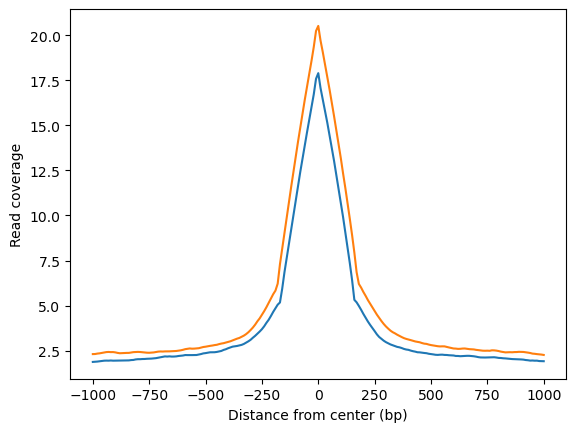

In [12]:
#Plot our peak profiles overlapping each other
#Our histogram data is based on average coverage among all our called peaks that we gave HOMER

plt.plot(taz_1_profile['distance_from_center'],
         taz_1_profile['coverage']
        )

plt.plot(taz_2_profile['distance_from_center'],
         taz_2_profile['coverage']
        )

#pretty up plot
plt.xlabel('Distance from center (bp)')
plt.ylabel('Read coverage')

#Since we're now digging into our ChIP-seq data in more detail
#You'll always want to think about what the data is telling us about the biology that gave rise to that data
#In this case, you'll want to think about what does this type of peak profile tell us about TEAD+TAZ binding to DNA

#This tell us that it recognizes and binds specific spots in the genome based on the average coverage around each peak
#The shape of the peak profile tells us about how/where it binds

#In this case, our data gives us a very stereotypic peak profile for transcription factors
#Importantly also is that the two profiles are very similar - reproducible data

You can see in your plot that while the coverage pattern is similar between the two replicates, they vary slightly in their read depth, with taz_2 having overall higher coverage than taz_1. This is normally expected, since each replicate will have slightly different read counts. The important consideration is that the plot profiles look similar in their shape.

Looking at the shape of both of our peak profiles, we can see that it is a sharp, narrow peak profile which is characteristic of the peak profiles for transcription factors as they recognize and bind to specific sequences in the genome based on what their DNA binding domains recognize. By plotting the peak profile, we can now see that TEAD+TAZ recognize and bind to a specific sequence as opposed to just broadly recognizing DNA. We'll later on pull together our peaks to identify the motif(s) recognized by TEAD when its bound to TAZ. 

<h1 style="font-size: 40px; margin-bottom: 0px;">Generate heatmap of coverage/read density</h1>

<hr style="margin-left: 0px; border: 0.25px solid; border-color: #000000; width: 98%;"></hr>

Among the documentation for <code>annotatePeaks.pl</code>, we can see that there is an additional option <code>-ghist</code> that we can specify, which will change the output generated by <code>annotatePeaks.pl</code>. In this case, rather than outputting the average coverage along all peaks, it will output a data matrix, where we are then able to see the coverage for each peak individually.

<h2>Create <code>heatmap</code> directory in <code>Week_8</code> and enter it</h2>

In [ ]:
%%bash

#We skipped this in class
#You can just output to plot-profile directory for convenience

<hr style="margin-left: 0px; border: 1px solid; border-color: #BBBBBB; width: 98%;"></hr>

<h2>Obtain data matrix for both TAZ replicates</h2>

In [ ]:
%%bash

#We can dig into documentation for annotatePeaks.pl
annotatePeaks.pl -help


#We initially got a histogram of average read coverage
#We can alter how annotatePeaks.pl operates
#so that we get a 2D data matrix
#each row will then be an individual peak
#columns will be a histogram still but of the coverage for that peak

annotatePeaks.pl \
~/MCB201B_F2025/Week_7/macs2/10M_taz_1_summits.bed \
hg19 \
-bedGraph ~/MCB201B_F2025/Week_7/macs2/10M_taz_1_treat_pileup.bdg \
-size 2000 \
-hist 10 \
-ghist > 10M_taz_1_heatmap.txt

So you can see that we run the code with the same input, except now we add in an additional option <code>-ghist</code>, which changes how it outputs the coverage data.

<hr style="margin-left: 0px; border: 1px solid; border-color: #BBBBBB; width: 98%;"></hr>

<h2>Import our data matrices</h2>

Let's go ahead and import our data matrices, and then to simplify plotting, we can drop the <code>'Gene'</code> column since we don't need that for our heatmaps.

In [14]:
#Import our data into this notebook
taz_1_heatmap = pd.read_csv('~/MCB201B_F2025/Week_8/plot-profile/10M_taz_1_heatmap.txt',
                            sep='\t',
                           )

taz_2_heatmap = pd.read_csv('~/MCB201B_F2025/Week_8/plot-profile/10M_taz_2_heatmap.txt',
                            sep='\t',
                           )

Let's do a quick sanity check.

In [15]:
taz_1_heatmap.head().style

,Gene,-1000,-990,-980,-970,-960,-950,-940,-930,-920,-910,-900,-890,-880,-870,-860,-850,-840,-830,-820,-810,-800,-790,-780,-770,-760,-750,-740,-730,-720,-710,-700,-690,-680,-670,-660,-650,-640,-630,-620,-610,-600,-590,-580,-570,-560,-550,-540,-530,-520,-510,-500,-490,-480,-470,-460,-450,-440,-430,-420,-410,-400,-390,-380,-370,-360,-350,-340,-330,-320,-310,-300,-290,-280,-270,-260,-250,-240,-230,-220,-210,-200,-190,-180,-170,-160,-150,-140,-130,-120,-110,-100,-90,-80,-70,-60,-50,-40,-30,-20,-10,0,10,20,30,40,50,60,70,80,90,100,110,120,130,140,150,160,170,180,190,200,210,220,230,240,250,260,270,280,290,300,310,320,330,340,350,360,370,380,390,400,410,420,430,440,450,460,470,480,490,500,510,520,530,540,550,560,570,580,590,600,610,620,630,640,650,660,670,680,690,700,710,720,730,740,750,760,770,780,790,800,810,820,830,840,850,860,870,880,890,900,910,920,930,940,950,960,970,980,990,1000
0,10M_taz_1_peak_1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,1,1,1,2,2,2,2,2,2,2,2,2,2,2,2,2,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,1,1,1,2,2,3,4,4,6,7,8,9,11,12,15,15,14,15,16,15,16,15,15,15,14,12,12,12,10,9,6,6,6,5,5,4,3,3,3,3,3,3,2,2,2,2,1,1,1,1,1,2,2,2,1,1,1,1,1,1,1,1,1,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,10M_taz_1_peak_2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,2,2,3,3,2,2,2,2,3,3,3,3,3,3,3,3,2,2,1,1,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,2,1,1,1,1,1,1,2,2,3,3,3,3,3,3,3,5,6,7,7,10,11,11,10,10,11,10,10,10,11,11,12,10,8,7,7,5,4,3,3,3,3,3,3,3,2,2,2,3,3,3,3,4,4,4,4,4,3,3,3,4,4,4,4,5,4,4,5,5,5,5,6,6,6,6,6,6,5,5,4,3,3,3,3,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,2,2,2,2,2,2,2,3,3,3,3,3,3,3,3,3,2
2,10M_taz_1_peak_3,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,2,3,3,3,3,3,3,3,3,3,5,6,6,6,6,7,7,6,6,7,8,10,12,13,14,14,13,12,12,12,11,10,10,10,10,9,8,6,4,3,2,2,3,2,2,3,3,3,2,2,2,2,2,3,3,3,3,3,3,2,2,2,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,2,2,2,2,2,2,2
3,10M_taz_1_peak_4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,2,1,1,1,1,1,1,1,1,1,2,2,3,4,4,5,5,6,6,6,6,6,6,6,6,6,5,6,7,5,5,4,4,3,3,3,3,3,4,4,4,5,5,4,3,4,5,4,4,4,4,4,4,4,3,3,3,2,2,3,3,2,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,1,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1
4,10M_taz_1_peak_5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,1,0,0,0,0,0,0,1,1,3,3,3,4,4,4,4,4,4,6,7,7,7,7,6,6,5,4,6,5,6,6,7,7,7,6,5,4,4,4,4,4,4,4,2,3,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


<hr style="margin-left: 0px; border: 1px solid; border-color: #BBBBBB; width: 98%;"></hr>

<h2>Generate heatmaps for both replicates</h2>

With everything imported, now we can make use of either <code>matplotlib</code> or <code>seaborn</code> to generate our heatmaps. For this example, we'll make use of <code>sns.heatmap()</code>. <a href="https://seaborn.pydata.org/generated/seaborn.heatmap.html" rel="noopener noreferrer">Documentation for <code>sns.heatmap()</code> can be found here.</u></a>

In [16]:
#We don't need the 'Gene' column for plotting, so we can drop it
taz_1_heatmap.drop(columns=['Gene'], inplace=True)
taz_2_heatmap.drop(columns=['Gene'], inplace=True)

In [17]:
taz_1_heatmap.head().style

,-1000,-990,-980,-970,-960,-950,-940,-930,-920,-910,-900,-890,-880,-870,-860,-850,-840,-830,-820,-810,-800,-790,-780,-770,-760,-750,-740,-730,-720,-710,-700,-690,-680,-670,-660,-650,-640,-630,-620,-610,-600,-590,-580,-570,-560,-550,-540,-530,-520,-510,-500,-490,-480,-470,-460,-450,-440,-430,-420,-410,-400,-390,-380,-370,-360,-350,-340,-330,-320,-310,-300,-290,-280,-270,-260,-250,-240,-230,-220,-210,-200,-190,-180,-170,-160,-150,-140,-130,-120,-110,-100,-90,-80,-70,-60,-50,-40,-30,-20,-10,0,10,20,30,40,50,60,70,80,90,100,110,120,130,140,150,160,170,180,190,200,210,220,230,240,250,260,270,280,290,300,310,320,330,340,350,360,370,380,390,400,410,420,430,440,450,460,470,480,490,500,510,520,530,540,550,560,570,580,590,600,610,620,630,640,650,660,670,680,690,700,710,720,730,740,750,760,770,780,790,800,810,820,830,840,850,860,870,880,890,900,910,920,930,940,950,960,970,980,990,1000
0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,1,1,1,2,2,2,2,2,2,2,2,2,2,2,2,2,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,1,1,1,2,2,3,4,4,6,7,8,9,11,12,15,15,14,15,16,15,16,15,15,15,14,12,12,12,10,9,6,6,6,5,5,4,3,3,3,3,3,3,2,2,2,2,1,1,1,1,1,2,2,2,1,1,1,1,1,1,1,1,1,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,2,2,3,3,2,2,2,2,3,3,3,3,3,3,3,3,2,2,1,1,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,2,1,1,1,1,1,1,2,2,3,3,3,3,3,3,3,5,6,7,7,10,11,11,10,10,11,10,10,10,11,11,12,10,8,7,7,5,4,3,3,3,3,3,3,3,2,2,2,3,3,3,3,4,4,4,4,4,3,3,3,4,4,4,4,5,4,4,5,5,5,5,6,6,6,6,6,6,5,5,4,3,3,3,3,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,2,2,2,2,2,2,2,3,3,3,3,3,3,3,3,3,2
2,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,2,3,3,3,3,3,3,3,3,3,5,6,6,6,6,7,7,6,6,7,8,10,12,13,14,14,13,12,12,12,11,10,10,10,10,9,8,6,4,3,2,2,3,2,2,3,3,3,2,2,2,2,2,3,3,3,3,3,3,2,2,2,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,2,2,2,2,2,2,2
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,2,1,1,1,1,1,1,1,1,1,2,2,3,4,4,5,5,6,6,6,6,6,6,6,6,6,5,6,7,5,5,4,4,3,3,3,3,3,4,4,4,5,5,4,3,4,5,4,4,4,4,4,4,4,3,3,3,2,2,3,3,2,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,1,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,1,0,0,0,0,0,0,1,1,3,3,3,4,4,4,4,4,4,6,7,7,7,7,6,6,5,4,6,5,6,6,7,7,7,6,5,4,4,4,4,4,4,4,2,3,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


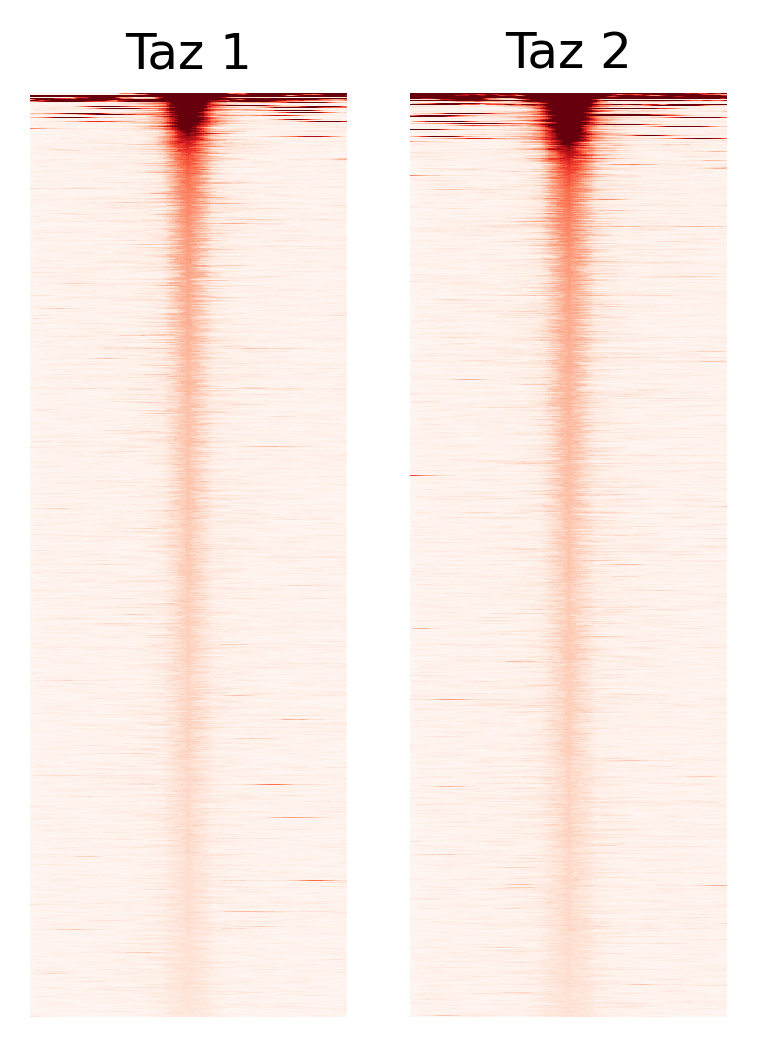

In [20]:
#Create 2 subplots side by side using our usu method
fig, ax = plt.subplots(1, 2, figsize=(3, 4))

#Use seaborn's heatmap function
#We pass it our 2D data matrix
#while simultaneously sorting based on max center value
#so whatever peak has highest coverage at the summit/peak center ('0')
#that will be up top in our 2D matrix
sns.heatmap(taz_1_heatmap.sort_values(by='0', ascending=False),
            vmin=0, #Like with plt.imshow we can specify bounds for intensities
            vmax=60, #Same here
            cmap='Reds', #We can adjust color map like plt.imshow
            cbar=False, #Hide the color bar
            yticklabels=False, #Hide the ytick labels
            xticklabels=False, #Hide the xtick labels
            ax=ax[0] #Plot it on our first subplot
           )

#Repeat for second taz replicate, but plot onto second subplot ax[1]
sns.heatmap(taz_2_heatmap.sort_values(by='0', ascending=False),
            vmin=0,
            vmax=60,
            cmap='Reds',
            cbar=False,
            yticklabels=False,
            xticklabels=False,
            ax=ax[1]
           )

#Pretty up stuff
ax[0].set_title('Taz 1')
ax[1].set_title('Taz 2')

fig.set_dpi(300)
plt.show()

#You should now see coverage density for each peak now in a heatmap format
#So instead of average profile, we visualize each peak's coverage in a heatmap
#This is another common way of plotting coverage data
#This also allows us to get an overview of how our peaks look

<h1 style="font-size: 40px; margin-bottom: 0px;">Plot TSS-centric read distribution</h1>

<hr style="margin-left: 0px; border: 0.25px solid; border-color: #000000; width: 98%;"></hr>

The multifunctionality of <code>annotatePeaks.pl</code> means that we can also perform a transcription start site (TSS)-centric analysis. In this case, we can supply the program with the <code>tss</code> argument along with our bedGraph files, so it can provide us with the distribution of reads around TSSs. This can help give us an idea into if our protein of interest is regulating its target genes via promoter binding or through more distant interactions.

<h2>Obtain read distributions around TSS</h2>

In [ ]:
%%bash

#Thinking back to the biology
#We know that regulators of transcription bind to the promoter region
#Which is by the transcription start site
#We can adjust how annotatePeaks.pl runs to instead focus on transcription start sites
#So we can then plot the coverage around transcription start sites
#This can tell us more about how TEAD+TAZ is regulating gene transcription

annotatePeaks.pl \
tss \
hg19 \
-bedGraph ~/MCB201B_F2025/Week_7/macs2/10M_taz_1_treat_pileup.bdg \
-size 8000 \
-hist 10 > 10M_taz_1_tss_profile.txt

Here, we make minor alterations to how we ran the annotatePeaks program to instruct it to focus on TSSs and to provide a larger region of interest. So we provide the <code>tss</code> argument and increase the <code>-size</code> to <code>8000</code>. That way, we'll get an output containing the read distribution centered around TSSs, which we can plot like we did with the summit profile.

<h1 style="font-size: 40px; margin-bottom: 0px;">Exercise set 2</h1>

<hr style="margin-left: 0px; border: 0.25px solid; border-color: #000000; width: 98%;"></hr>

<h2>Exercise #1: Obtain read distributions around TSS for 10M_taz_2</h2>

Now give it a try to update your input to instead analyze the distribution around TSSs for 10M_taz_2.

In [ ]:
%%bash

#Do the same thing for our second replicate

annotatePeaks.pl \
tss \
hg19 \
-bedGraph ~/MCB201B_F2025/Week_7/macs2/10M_taz_2_treat_pileup.bdg \
-size 8000 \
-hist 10 > 10M_taz_2_tss_profile.txt

<h2>Exercise #2: Import your TSS analysis outputs</h2>

In [3]:
#Import our data into this notebook
#We are essentially following the same method that we used to plot peak profile in Exercise Set 1
taz_1_tss = pd.read_csv('~/MCB201B_F2025/Week_8/plot-profile/10M_taz_1_tss_profile.txt',
                        sep='\t'
                       )

taz_2_tss = pd.read_csv('~/MCB201B_F2025/Week_8/plot-profile/10M_taz_2_tss_profile.txt',
                        sep='\t',
                       )

#Sanity check
taz_1_tss.head().style

,Distance from Center (cmd=annotatePeaks.pl tss hg19 -bedGraph /home/jovyan/MCB201B_F2025/Week_7/macs2/10M_taz_1_treat_pileup.bdg -size 8000 -hist 10),/home/jovyan/MCB201B_F2025/Week_7/macs2/10M_taz_1_treat_pileup.bdg Coverage,/home/jovyan/MCB201B_F2025/Week_7/macs2/10M_taz_1_treat_pileup.bdg + Tags,/home/jovyan/MCB201B_F2025/Week_7/macs2/10M_taz_1_treat_pileup.bdg - Tags
0,-4000,0.588917,0.014113,0.014380
1,-3990,0.591411,0.012937,0.012688
2,-3980,0.592038,0.013916,0.013854
3,-3970,0.594470,0.014405,0.014162
4,-3960,0.593622,0.014789,0.014873


Like with our plot profiles earlier, update the column headers for convenience.

<ol>
    <li><code>'distance_from_center'</code></li>
    <li><code>'coverage'</code></li>
    <li><code>'plus_tags'</code></li>
    <li><code>'minus_tags'</code></li>
</ol>

In [22]:
#Update column headers
taz_1_tss.columns = ['distance_from_center',
                     'coverage',
                     'plus_tags',
                     'minus_tags'
                    ]

taz_2_tss.columns = ['distance_from_center',
                     'coverage',
                     'plus_tags',
                     'minus_tags'
                    ]
#Sanity check
taz_1_tss.columns

Index(['distance_from_center', 'coverage', 'plus_tags', 'minus_tags'], dtype='object')

<h2>Exercise #3: Plot the coverage around TSS for both replicates</h2>

Once you've imported your datasets, go ahead and plot the coverage around TSSs, using the same approach that you used for plotting the peak profile.

Text(0, 0.5, 'Read coverage')

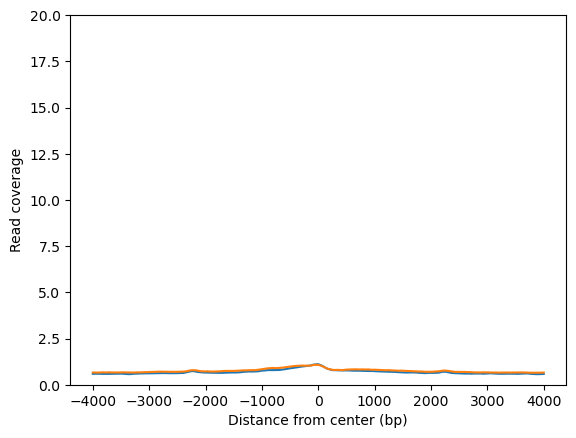

In [26]:
#Like with Exercise Set 1, we can overlay our line plots
plt.plot(taz_1_tss['distance_from_center'],
         taz_1_tss['coverage']
        )

plt.plot(taz_2_tss['distance_from_center'],
         taz_2_tss['coverage']
        )


#Update our ylimits
#We know based on our peak profile from Exercise 1 what the y limits are for positive coverage
plt.ylim(0, 20)
#Pretty up things
plt.xlabel('Distance from center (bp)') #Can also replace "center" with "TSS" to be more clear
plt.ylabel('Read coverage')


#Take a look at plot
#Think about biology
#Will want to consider what this is telling us about TEAD+TAZ and where it binds to DNA
#In this case, we basically have no coverage in a region +/-4kb around TSS
#So then that means TEAD+TAZ is regulating transcription not by promoter binding

#Instead this data is telling us that TEAD+TAZ are likely binding somewhere else
#Basically suggest that they bind to enhancer regions that can be much further away
#Recall that enhancers don't have to be directly next to the TSS but can be 10s or 100s of kb away

#We paused here :)

What does the distribution tell us about the way that TEAD+TAZ is potentially regulating gene transcription?

<h1 style="font-size: 40px; margin-bottom: 0px;">Determine distance from TSS</h1>

<hr style="margin-left: 0px; border: 0.25px solid; border-color: #000000; width: 98%;"></hr>

The results that we get when we look at the average coverage around TSSs seem to suggest that our peaks may be more distant than &pm;4kbp. What we can then do is take a look at the distribution of distances that our peaks are located from their nearest TSS. That can help give us a little bit more insight into our above result.

We'll once again make use of <code>annotatePeaks.pl</code> with slight modifications. If we take a look at <a href="http://homer.ucsd.edu/homer/ngs/annotation.html" rel="noopener noreferrer"><u>the documentation for <code>annotatePeaks.pl</code></u></a>, among one of the outputs for its basic annotate function is a column containing information on the distance to the nearest TSS, which is what we're interested in.

So we can use the basic annotate function of <code>annotatePeaks.pl</code> and focus on TSS annotations.

<h2>Create new directory <code>annotation</code> in this week's directory</h2>

Let's make a new directory <code>annotation</code>, and then enter it too.

In [ ]:
%%bash

#Make our directory
mkdir annotation

#Then enter it
cd annotation

<hr style="margin-left: 0px; border: 1px solid; border-color: #BBBBBB; width: 98%;"></hr>

<h2>Annotate to find distance to nearest TSS for 10M_taz_1</h2>

Now lets modify how <code>annotatePeaks.pl</code> runs, and this time have it return to us the distances to TSSs for each peak summit.

In [ ]:
%%bash

#We continue to make use of annotatePeaks.pl
#This time setting it up to run differently
#Now will just annotate distance to nearest TSS
#Detailed breakdown of code in Markdown cell below
annotatePeaks.pl \
~/MCB201B_F2025/Week_7/macs2/10M_taz_1_summits.bed \
hg19 \
-noann > 10M_taz_1_annotation.txt

<h2>Let's breakdown the code:</h2>

<code>annotatePeaks.pl</code>

This calls up the annotatePeaks program within HOMER.

<hr style="border: 1px solid; border-color: #BBBBBB;"></hr>

<code>~/MCB201B_F2025/Week_7/macs2/10M_taz_1_summits.bed</code>

Here, we are providing the annotatePeaks program with a bed file containing the coordinates for our peak summits. This time we're interested in identifying the distances of our summits to the nearest TSS.

<hr style="border: 1px solid; border-color: #BBBBBB;"></hr>

<code>hg19</code>

We indicate that we want to use the hg19 genome, which we have installed.

<hr style="border: 1px solid; border-color: #BBBBBB;"></hr>

<code>-noann</code>

This option alters how the annotatePeaks program runs. By default the program will mark peak locations based on the genomic feature in which its located (intron, exon, TSS, CDS, etc), and the program will also identify the nearest gene and TSS. By providing the <code>-noann</code>, we are instructing the annotatePeaks program not to annotate peaks for genomic features, and instead, just focus on identifying nearby genes and TSSs. 

<hr style="border: 1px solid; border-color: #AAAAAA;"></hr>

<code>&gt; 10M_taz_1_annotation.txt</code>

We redirect the output data into a .txt file that we can then load into Python in order to pull relevant information.

<h1 style="font-size: 40px; margin-bottom: 0px;">Exercise Set 3</h1>

<hr style="margin-left: 0px; border: 0.25px solid; border-color: #000000; width: 98%;"></hr>

<h2>Exercise #1: Obtain distance to nearest TSS for 10M_taz_2</h2>

Run <code>annotatePeaks.pl</code> now for 10M_taz_2 to identify the distance to the nearest TSS.

In [ ]:
%%bash

#Run the same thing now for second replicate
annotatePeaks.pl \
~/MCB201B_F2025/Week_7/macs2/10M_taz_2_summits.bed \
hg19 \
-noann > 10M_taz_2_annotation.txt

<h2>Exercise #2: Import your outputs</h2>

Now go ahead and import your output files containing the distances to the nearest TSS for each replicate.

In [8]:
#Import our files in the usual way
taz_1_annotation = pd.read_csv('./annotation/10M_taz_1_annotation.txt',
                               sep='\t'
                              )

taz_2_annotation = pd.read_csv('./annotation/10M_taz_2_annotation.txt',
                               sep='\t'
                              )

In [5]:
#Sanity check
taz_2_annotation.head().style

,PeakID (cmd=annotatePeaks.pl /home/jovyan/MCB201B_F2025/Week_7/macs2/10M_taz_2_summits.bed hg19 -noann),Chr,Start,End,Strand,Peak Score,Focus Ratio/Region Size,Annotation,Detailed Annotation,Distance to TSS,Nearest PromoterID,Entrez ID,Nearest Unigene,Nearest Refseq,Nearest Ensembl,Gene Name,Gene Alias,Gene Description,Gene Type
0,10M_taz_2_peak_1145,chr14,62222191,62222191,+,346.613000,nan,nan,nan,-4376.000000,NR_144368,105370526.000000,nan,NR_144368,ENSG00000258667,HIF1A-AS3,HIFAL,HIF1A antisense RNA 3,ncRNA
1,10M_taz_2_peak_1603,chr19,1383503,1383503,+,194.585000,nan,nan,nan,-403.000000,NM_001363602,374291.000000,nan,NM_024407,ENSG00000115286,NDUFS7,CI-20|CI-20KD|MC1DN3|MY017|PSST,NADH:ubiquinone oxidoreductase core subunit S7,protein-coding
2,10M_taz_2_peak_712,chr11,59318654,59318654,+,190.546000,nan,nan,nan,36268.000000,NM_001004711,390199.000000,nan,NM_001004711,ENSG00000172742,OR4D9,OR11-253,olfactory receptor family 4 subfamily D member 9,protein-coding
3,10M_taz_2_peak_3458,chr9,137029712,137029712,+,182.832000,nan,nan,nan,-26.000000,NR_023344,100151684.000000,nan,NR_023344,ENSG00000221676,RNU6ATAC,RNU6ATAC1|U6ATAC,"RNA, U6atac small nuclear",snRNA
4,10M_taz_2_peak_1428,chr17,37310098,37310098,+,178.101000,nan,nan,nan,-2208.000000,NM_020405,57125.000000,nan,NM_020405,ENSG00000161381,PLXDC1,TEM3|TEM7,plexin domain containing 1,protein-coding


Update the first column's header real quick to <code>'Peak ID'</code> for convenience.

In [10]:
#We can rename the column header
#Can pull the first column header by using taz_1_annotation.columns[0]
#That way, we don't have to type it out or copy it over when we rename it
taz_1_annotation.rename(columns={taz_1_annotation.columns[0]: 'Peak ID'}, 
                                inplace=True
                       )

In [11]:
#Same here, saves us the hassle
#Also makes the code more flexible/adaptable
#Since the column header in the first position changes based on our command line input
taz_2_annotation.rename(columns={taz_2_annotation.columns[0]: 'Peak ID'}, 
                                inplace=True
                       )

<h2>Exercise #2: Calculate the absolute value of distances for each peak</h2>

Since our dataset contains both positive and negative distances for <code>'Distance to TSS'</code>, which just indicate relative position to the TSS either upstream or downstream, calculate the absolute value of the distances, since we're only really interested in how far away is TEAD+TAZ binding for this exercise.

In [13]:
#Calculate absolute value and assign it to a new column that we call up
taz_1_annotation['absolute_distance_to_tss'] = taz_1_annotation['Distance to TSS'].abs()
taz_2_annotation['absolute_distance_to_tss'] = taz_2_annotation['Distance to TSS'].abs()

Let's convert to kilobases for convenience.

In [14]:
#Similar thing here, we divide by 1000 to get kb and assign to a new column that we call up
taz_1_annotation['absolute_distance_to_tss_kb'] = taz_1_annotation['absolute_distance_to_tss'] / 1000
taz_2_annotation['absolute_distance_to_tss_kb'] = taz_2_annotation['absolute_distance_to_tss'] / 1000

In [15]:
#Sanity check
taz_1_annotation.head().style

,Peak ID,Chr,Start,End,Strand,Peak Score,Focus Ratio/Region Size,Annotation,Detailed Annotation,Distance to TSS,Nearest PromoterID,Entrez ID,Nearest Unigene,Nearest Refseq,Nearest Ensembl,Gene Name,Gene Alias,Gene Description,Gene Type,absolute_distance_to_tss,absolute_distance_to_tss_kb
0,10M_taz_1_peak_1347,chr14,62222163,62222163,+,270.377000,nan,nan,nan,-4348.000000,NR_144368,105370526.000000,nan,NR_144368,ENSG00000258667,HIF1A-AS3,HIFAL,HIF1A antisense RNA 3,ncRNA,4348.000000,4.348000
1,10M_taz_1_peak_1912,chr19,1383513,1383513,+,208.115000,nan,nan,nan,-393.000000,NM_024407,374291.000000,nan,NM_024407,ENSG00000115286,NDUFS7,CI-20|CI-20KD|MC1DN3|MY017|PSST,NADH:ubiquinone oxidoreductase core subunit S7,protein-coding,393.000000,0.393000
2,10M_taz_1_peak_31,chr1,19379131,19379131,+,170.289000,nan,nan,nan,-95961.000000,NM_001136265,126917.000000,nan,NM_001136265,ENSG00000169991,IFFO2,-,intermediate filament family orphan 2,protein-coding,95961.000000,95.961000
3,10M_taz_1_peak_1768,chr17,73030628,73030628,+,155.876000,nan,nan,nan,1962.000000,NR_110835,23510.000000,nan,NM_015353,ENSG00000180901,KCTD2,-,potassium channel tetramerization domain containing 2,protein-coding,1962.000000,1.962000
4,10M_taz_1_peak_278,chr1,161369601,161369601,+,153.591000,nan,nan,nan,-31935.000000,NM_001013625,257177.000000,nan,NM_001013625,ENSG00000188931,CFAP126,C1orf192|Flattop|Fltp,cilia and flagella associated protein 126,protein-coding,31935.000000,31.935000


<h2>Exercise #3: Plot a histogram of the distribution of distances</h2>

Now see if you can plot a histogram of the distribution of distances according to the following bins:

<ul>
    <li>From 0kb to 1kb</li>
    <li>From 1kb to 10kb</li>
    <li>From 10kb to 100kb</li>
    <li>>100kb</li>
</ul>

/srv/conda/lib/python3.11/site-packages/matplotlib/axes/_axes.py:7160: RuntimeWarning: invalid value encountered in multiply
  boffset = -0.5 * dr * totwidth * (1 - 1 / nx)


(array([ 303.,  825., 2365.,  810.]),
 array([  0.,   1.,  10., 100.,  inf]),
 <BarContainer object of 4 artists>)

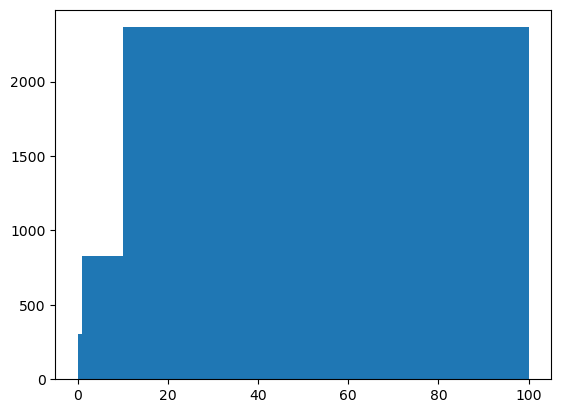

In [16]:
#First attempt to plot histogram
fun_bins = [0, 1, 10, 100, np.inf]

#Because the distances covered by the bins are unequal, we get a wonky looking histogram
plt.hist(taz_1_annotation['absolute_distance_to_tss_kb'],
         bins=fun_bins
        )

In [17]:
#So we can a bit more manually set up the bins
extra_fun_bins = [[0, 1], [1, 10], [10, 100], [100, np.inf]]

In [22]:
#And we can pull the counts within those ranges in our extra fun bins
print(taz_1_annotation['absolute_distance_to_tss'].value_counts(bins=[100, np.inf]))

(99.999, inf]    4211
Name: absolute_distance_to_tss, dtype: int64


In [32]:
#We can pull out just the counts
taz_1_annotation['absolute_distance_to_tss_kb'].value_counts(bins=[100, np.inf]).item()

4211

In [35]:
#Initialize empty lists
taz_1_bins = []
taz_2_bins = []

#Run our for-loop to get our counts
for bins in extra_fun_bins:
    taz_1_bins.append(taz_1_annotation['absolute_distance_to_tss_kb'].value_counts(bins=bins).item())
    taz_2_bins.append(taz_2_annotation['absolute_distance_to_tss_kb'].value_counts(bins=bins).item())

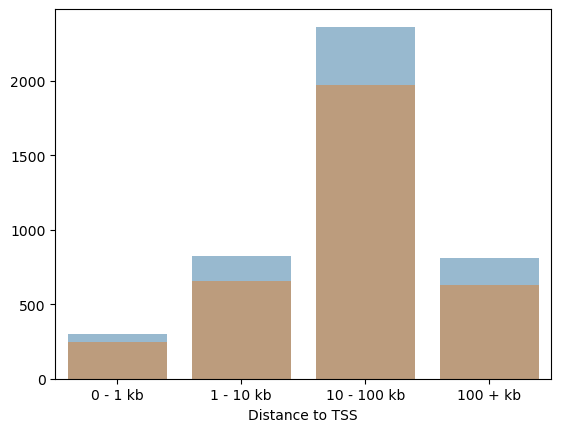

In [41]:
#Set up a plot in the usu way
fig, ax = plt.subplots()

#This time, we can instead plot using barplot
#In a way, our bins are like categories, so we can use this workaround
sns.barplot(taz_1_bins,
            alpha=0.5
           )

sns.barplot(taz_2_bins,
            alpha=0.5
           )

#Pretty up plot
plt.xlabel('Distance to TSS')
plt.xticks(np.arange(0, 4, 1),
           ['0 - 1 kb',
            '1 - 10 kb',
            '10 - 100 kb',
            '100 + kb'
           ]
          )

plt.show()

#Can see that it is roughly consistent between both replicates
#Thinking back to the biology
#This indicates that TEAD+TAZ are binding pretty far away from TSS
#With most of the binding occurring between 10kb and 100kb away from the TSS
#Which means that there needs to be mechanism to bring TEAD+TAZ to the promoter they're regulating
#Recall from Zoncanato et al 2015 - regulation by distant enhancer is facilitated by the looping structures
#identified by the 3C technique in the paper

What do the distribution of peak distances to the nearest TSS suggest to us about how TAZ is regulating gene expression?

<h1 style="font-size: 40px; margin-bottom: 0px;">Find concordant peaks between two replicates</h1>

<hr style="margin-left: 0px; border: 0.25px solid; border-color: #000000; width: 98%;"></hr>

Currently, we have two replicates with thousands of identified peaks that were found to be significant compared to the background levels (using our pooled IgG sequencing data). However, not all those peaks will be the same between replicates, due to biological and experimental variability, so we'll want to focus on just those peaks that are present in both our replicates for a more focused downstream analysis.

<h2>HOMER's mergePeaks program</h2>

To find peaks that are shared between our two replicates, we will make use of the <code>mergePeaks</code> command, and we'll provide it with the .narrowPeak files for both our replicates for analysis.

<a href="http://homer.ucsd.edu/homer/ngs/mergePeaks.html" rel="noopener noreferrer"><u>Documentation for the <code>mergePeaks</code> utility can be found here.</u></a>

If we take a look at the command line structure to use this program to pull overlapping peaks:

<pre style="width: 750px; margin-top: 15px; margin-bottom: 15px; color: #000000; background-color: #EEEEEE; border: 1px solid; border-color: #AAAAAA; padding: 10px; border-radius: 15px; font-size: 12px;">mergePeaks -d &lt;max distance to merge&gt; &lt;peak file 1&gt; &lt;peak file 2&gt; &lbrack;peak file N&rbrack; &lbrack;options&rbrack; -prefix &lt;base name&gt;</pre>

In [ ]:
%%bash

<h2>Let's breakdown the code:</h2>

<code>mergePeaks</code>

Here, we are calling up the mergePeaks program.

<hr style="border: 1px solid; border-color: #AAAAAA;"></hr>

<code>-d 100</code>

Here, we provide the program with the maximum distance that we would like it to merge peaks based on the distance between the peak centers. So peaks whose centers are greater than 100bp apart will not be considered overlapping.

<hr style="border: 1px solid; border-color: #AAAAAA;"></hr>

<code>~/MCB201B_F2025/Week_7/macs2/10M_taz_1_peaks.narrowPeak</code>

The .narrowPeak file corresponding to our first replicate that we want it to pull peak information from.

<hr style="border: 1px solid; border-color: #AAAAAA;"></hr>

<code>~/MCB201B_F2025/Week_7/macs2/10M_taz_1_peaks.narrowPeak</code>

The .narrowPeak file corresponding to our second replicate. mergePeaks will identify the overlapping peaks from the two files we supply it. We can also supply it with additional files, and it will analyze all of them.

<hr style="border: 1px solid; border-color: #AAAAAA;"></hr>

<code>-prefix merged</code>

Here, we supply it with the basename that we want it to add to all the files that it outputs. Based on how we set up the command, we will have three output files, two that correspond to unique peaks present in their respective replicates and one that contains the information on overlapping peaks, which is the file that we're most interested in.

<h2>Simplify output file names</h2>

If you take a look in your File Browser, you can see the three outputs, and they have rather long, unwieldy names, especially the file containing our overlapping peaks. So let's just directly in the File Browser rename the files for simplicity's sake.

Rename the file containing the overlapping peaks to: <code>merged_taz_peaks.narrowPeak</code>

<hr style="margin-left: 0px; border: 1px solid; border-color: #BBBBBB; width: 98%;"></hr>

<h2>Import <code>merged_taz_peaks.narrowPeak</code> as a DataFrame</h2>

Now let's take a look at the information contained within the file by importing into our Python notebook.

First, import the .narrowPeak file containing the merged peaks.

Now let's take a look to see if it imported okay.

So we can see that the column headers are a bit long, so we can shorten things for our sake later on by using the <code>pd.DataFrame.rename()</code> function.

And let's check to see if it updated properly:

Now that we have our overlapping peaks, it's not enough to just know which peaks are shared between our two replicates. We also need to know how reproducible these peaks are between our two replicates.

<h2>Assessing reproducibility</h2>

Dr. Ingolia mentioned in lecture that between replicates, there is variability in which peaks are called as well as their significance, which can be due to normal biological or experimental variability. <a href="https://doi.org/10.1101/gr.136184.111" rel="noopener noreferrer"><u>The standard way (set by the ENCODE and modeENCODE consortia)</u></a> of determining if the peaks that we identify through our peak calling program is to calculate the Irreproducible Discovery Rate (IDR), developed by <a href="https://doi.org/10.1214/11-AOAS466" rel="noopener noreferrer"><u>Li et al 2011</u></a>. 

The IDR framework allows for us to determine the reproducibility of our peaks (or in general the findings of high-throughput experiments) by comparing replicates to one another. IDR provides us with a quantitative assessment of when two replicates are no longer consistent with one another, which could point to findings that are less reproducible. In our case, that would suggest that those peaks may not necessarily be reproducible in repeated experiments. It's in a way conceptually similar to the FDR, where a lower IDR indicates a lower chance that the peak is irreproducible.

We'll just take a qualitative look at the concordance of our data, which will give us an idea of which peaks are probably more consistent between our replicates. And then we'll use those peaks for motif discovery.

To do this, we'll first need our original <code>.narrowPeak</code> files, so that we can rank the peaks according to their significance <code>'-log10(qvalue)'</code>. Then we can use our <code>merged_taz_peaks.narrowPeak</code> file containing our overlapping peaks to pull all the information only for the overlapping peaks. And then we can plot the two replicates against one another to see how correlated the ranks are for each of the overlapping peaks. We can also do the same for the significance of each overlapping peak.

<h1 style="font-size: 40px; margin-bottom: 0px;">Exercise Set 3</h1>

<hr style="margin-left: 0px; border: 0.25px solid; border-color: #000000; width: 98%;"></hr>

<h2>Exercise #1: Import <code>.xls</code> files for both replicates</h2>

Let's import our original <code>.xls</code> files that was output by <code>macs2</code>, so we have all the information for each peak.

Let's check to see how the file imported.

<h2>Exercise #2: Rank data according to the <code>'-log10(qvalue)'</code></h2>

Now, we'll want to rank all the peaks according to their significance, with the greatest <code>'-log10(qvalue)'</code> having the assigned rank of 1. 

So we'll need to sort our data based on the <code>'-log10(qvalue)'</code>, and then we can assign ranks to each peak.

<h2>Guided Exercise: Pull together taz_1 peaks and taz_2 peaks based on the overlapping peaks</h2>

Now that we've ranked our individual replicates, we'll go ahead and then use our imported merged peaks to pull together the DataFrames for both replicates. To do this, we'll make use of the <code>pd.DataFrame.merge()</code> function, which will allow us to merge together two DataFrames based on a key or index. 

<a href="https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.merge.html" rel="noopener noreferrer"><u>Documentation for <code>pd.DataFrame.merge()</code> can be found here.</u></a>

Digging into the documentation, we can see that the function is set up such that the DataFrame preceding the <code>.merge()</code> is the "left" DataFrame to be merged, while the DataFrame passed as an argument to the <code>.merge()</code> is the "right" DataFrame to be merged.

We can also provide it with the column containing the values that will act as the key that the merge will be based on with the <code>left_on</code> and <code>right_on</code> parameters. And if we want to distinguish the source of the columns after the merge, we can add suffixes to the column names (if the column name is shared between both DataFrames).

<h2>Exercise #3: Plot each replicates' ranks against each other</h2>

We can then plot the peaks' ranks against one another to visualize the reproducibility of our dataset. For this exercise, plot the ranks for taz_1 peaks on the x-axis and the ranks for the corresponding taz_2 peaks on the y-axis as a scatter plot.

What you should be able to see is a plot that begins to fan out as the value for the rank increases (so overall less significant peak), suggesting that those peaks identified in either set that do not have a high -log10(qvalue) may not be very reproducible. So in our more focused analysis, we will want to avoid those peaks and just look into those that consistently rank high (rank values closer to 1).

<h2>Exercise #4: Plot significance of two replicates against one another</h2>

We can also do the same for the <code>'-log10(qvalue)'</code> of our overlapping peaks.

To visually increase the spread of the lower significance samples, we can log transform the <code>'-log10(qvalue)'</code> using <code>np.log10()</code> when we plot each data point.

Alternatively, you can change the x- and y-axes to log scale.

Again, we can see that peaks that are highly significant in one replicate are likely to also be similarly significant in the second replicate, which suggest that they are more consistent between replicates. However, not all the peaks are necessarily highly consistent between our two replicates.

<h2>Exercise #5: Narrow down peaks to consistently high ranked peaks</h2>

For our motif discovery, we'll want to have a focused set of peaks to work with, so we can just focus on those peaks that are highly consistent between our two replicates. Normally, we would quantify the Irreproducible Discovery Rate (IDR), but here we'll just set a cut off of those peaks that are consistently in the top 500 in both replicates. See if you can pull just those highly reproducible peaks.

<h2>Exercise #6: Highlight the consistently high ranked peaks</h2>

Similar to what we did in notebook 7-2, let's highlight just the consistently high ranked peaks to visually distinguish them from the rest of the peaks in our scatter plot.

<h2>Exercise #7: Export your concordant peaks to a <code>.narrowPeak</code> file</h2>

Let's now export our top concordant peaks into a <code>.narrowPeak</code> file. Recall that the files that we've been working with are essentially plain text files with tabs as a delimiter to separate values that just have a custom file extension indicating that the file has a particular format/organization to its data. 

We can make use of <code>pd.DataFrame.read_csv()</code> to export our DataFrame containing our top concordant peaks. We don't need to export our <code>header</code> nor our <code>index</code>, so you'll have to modify how <code>.read_csv()</code> is running.

You can go ahead and export it to your <code>Week_8</code> directory.

<h1 style="font-size: 40px; margin-bottom: 0px;">Motif discovery</h1>

<hr style="margin-left: 0px; border: 0.25px solid; border-color: #000000; width: 98%;"></hr>

Let's return to Terminal and HOMER. Here, we'll make use of the core function of HOMER, which is to identify motifs. To do this, we'll need to go back to Terminal to run the <code>findMotifsGenome.pl</code> program. 

<a href="http://homer.ucsd.edu/homer/ngs/peakMotifs.html" rel="noopener noreferrer"><u>Documentation for <code>findMotifsGenome.pl</code> can be found here.</u></a>

If we look into the documentation, we can see that the basic command line structure to use this code is:

<pre style="width: 600px; margin-top: 15px; margin-bottom: 15px; color: #000000; background-color: #EEEEEE; border: 1px solid; border-color: #AAAAAA; padding: 10px; border-radius: 15px; font-size: 12px;">findMotifsGenome.pl &lt;peak file&gt; &lt;genome version&gt; &lt;output directory&gt; -size &#35; &lbrack;options&rbrack;</pre>

So to run the <code>findMotifsGenome.pl</code> program, we will supply it with our <code>.narrowPeak</code> file containing our focused list of overlapping and reproducible peaks, the genome version, an output directory, a fragment size, and any additional options.

In [ ]:
%%bash

<h2>Let's break down the code:</h2>

<code>findMotifsGenome.pl</code>

We call up the findMotifsGenome program.

<hr style="border: 1px solid; border-color: #AAAAAA;"></hr>

<code>~/MCB201B_F2025/Week_8/top_concordant_peaks.narrowPeak</code>

We provide it with our <code>.narrowPeak</code> file containing just our focused set of overlapping peaks.

<hr style="border: 1px solid; border-color: #AAAAAA;"></hr>

<code>hg19</code>

We indicate the genome version that it will use to pull sequences and find motifs. Recall that when we first set up HOMER, we preparsed the genome for 50bp fragments, and now we will be using that preparsed genome for motif discovery.

<hr style="border: 1px solid; border-color: #AAAAAA;"></hr>

<code>./</code>

We indicate the output directory as our current working directory.

<hr style="border: 1px solid; border-color: #AAAAAA;"></hr>

<code>-size 50</code>

We indicate the fragment size around the peak center where we want it to look for motifs. Here, it will look for motifs in the region &pm;50bp from the peak center.

<hr style="border: 1px solid; border-color: #AAAAAA;"></hr>

<code>-S 5</code>

This option specifies how many <i>de novo</i> motifs we want it to look for. The default option is 25, which is a lot. To keep the runtime down, we'll have it look for just 5 <i>de novo</i> motifs

<h2>Take a look at the identified motifs</h2>

Let's go ahead and take a look at the HTML output files to see what motifs we have identified within our peaks.

<h1 style="font-size: 40px; margin-bottom: 0px;">Visualize motif distributions</h1>

<hr style="margin-left: 0px; border: 0.25px solid; border-color: #000000; width: 98%;"></hr>

Now let's take a look at all the distribution of all our various TEAD motifs around our peak center just to get an idea of where TEAD might be binding relative to the center of our peaks, which we know should theoretically map to where TEAD+TAZ binds to DNA.

To do this, we'll make use of annotatePeaks' histogram mode, but we'll provide it with our TEAD motifs that we've found through our analysis. What annotatePeaks will do is go through our focused set of peaks and determine the distribution of our TEAD motifs around the center of all the peaks.

<h2>Obtain motif distributions around peaks</h2>

To make things a little more convenient, we'll stay in our <code>motif</code> directory but specify our output into our <code>annotation</code> directory.

In [ ]:
%%bash

<h2>Let's break down the code:</h2>

<code>annotatePeaks.pl</code>

This calls up the annotatePeaks program.

<hr style="border: 1px solid; border-color: #AAAAAA;"></hr>

<code>~/MCB201B_F2025/Week_8/top_concordant_peaks.narrowPeak</code>

This provides HOMER with our focused set of overlapping peaks.

<hr style="border: 1px solid; border-color: #AAAAAA;"></hr>

<code>hg19</code>

We specify the genome version.

<hr style="border: 1px solid; border-color: #AAAAAA;"></hr>

<code>-m</code>

This tells the program that we want it to do an analysis of a specific motif or set of motifs. In our case, we are providing it with motifs that we want it to use to determine their distributions within our focused set of peaks.

<hr style="border: 1px solid; border-color: #AAAAAA;"></hr>

<code>&lt;.motif files&gt;</code>

We provide the motif file(s) that we want the annotatePeaks program to use. We can supply it with a single motif file or more than one. In either case, the output will be a single file that contains information for each motif we provide it. Each motif will have 3 corresponding columns of data in the output: one for total counts, one for (+) counts, and one for (-) counts.

<hr style="border: 1px solid; border-color: #AAAAAA;"></hr>

<code>-size 2000</code>

We specify the size of the region of interest that we're interested in looking at motif distributions. With a size set to 2000, we will be looking at a region &pm;1000bp centered on our peaks.

<hr style="border: 1px solid; border-color: #AAAAAA;"></hr>

<code>-hist 20</code>

We invoke the histogram mode of annotatePeaks and provide it with the bin size that it will use to determine the distribution of motifs in our specified region.

<hr style="border: 1px solid; border-color: #AAAAAA;"></hr>

<code>&gt; motif_distribution.txt</code>

We redirect the output to a file called <code>motif_distribution.txt</code> that we can then import into this Python notebook to plot.

<h1 style="font-size: 40px; margin-bottom: 0px;">Exercise Set 4</h1>

<hr style="margin-left: 0px; border: 0.25px solid; border-color: #000000; width: 98%;"></hr>

This exercise set will have you plot the motif distributions of your TEAD motifs that you analyzed with HOMER. This way, we can get an idea of how the motifs are distributed around our peaks, which can tell us more about how TEAD+TAZ is recognizing and binding to DNA.

<h2>Exercise #1: Import motif distribution file</h2>

<h2>Exercise #2: Plot motif distributions as a line plot</h2>

For this exercise, see if you can plot the motif distributions for TEAD1-4 and TEAD (family). While there are still unwieldy column headers, we only really care about the ones for total sites, so we can pull those out to plot. We can just update the first column header and pull the others as needed when plotting.

What does this motif distribution tell us about how TEAD+TAZ binds to DNA?

<h1 style="font-size: 40px; margin-bottom: 0px;">References</h1>

<hr style="margin-left: 0px; border: 0.25px solid; border-color: #000000; width: 98%;"></hr>

<a href="https://www.nature.com/articles/ncb3216" rel="noopener noreferrer"><u>Zanconato et al 2015 Nat Cell Biol:</u></a> Genome-wide association between YAP/TAZ/TEAD and AP-1 at enhancers drives oncogenic growth

<a href="https://genome.cshlp.org/content/22/9/1813" rel="noopener noreferrer"><u>Landt et al 2012 Genome Res:</u></a> ChIP-seq guidelines and practices of the ENCODE and modENCODE consortia

<a href="https://projecteuclid.org/journals/annals-of-applied-statistics/volume-5/issue-3/Measuring-reproducibility-of-high-throughput-experiments/10.1214/11-AOAS466.full" rel="noopener noreferrer"><u>Li et al 2011 Ann Appl Stat:</u></a> Measuring reproducibility of high-throughput experiments